<a href="https://colab.research.google.com/github/urness/CS167Fall2025/blob/main/Day23_Baseline_Calculation_Solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## __Put the Model on Training Device (GPU or CPU)__


We want to accelerate the training process using graphical processing unit (GPU). Fortunately, in Colab we can access for GPU. You need to enable it from _Runtime (or click on the down arrow near RAM & DISK in upper right)-->Change runtime type-->GPU or TPU_

In [1]:
# check to see if torch.cuda is available, otherwise it will use CPU
import torch
import torch.nn as nn
import numpy as np
device = (
    "cuda"
    if torch.cuda.is_available()
    else "cpu"
)
print(f"Using {device} device")
# if it prints 'cuda' then colab is running using GPU device

Using cuda device


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#__Building Convolutional Neural Network (CNN)__

Create a network class with two methods:
- _init()_
- _forward()_


__Putting Everything Together using our AlexNet Network on our 4-class image recognition Dataset__

In [7]:
# Step 1: load the Torch library and other utilities
#----------------------------------------------------

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.autograd import Variable
from torchvision import transforms, datasets
from torchvision import models
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import pandas
import time
import numpy as np
import os
import pdb

# check to see if torch.cuda is available, otherwise it will use CPU
device = (
    "cuda"
    if torch.cuda.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


In [8]:
# Step 2: load the dataset (as we did above)
#--------------------------------------------------------------------------------------------------
# For fine-tuning with an AlexNet/VGG/ResNet architecture that has been pre-trained using the ImageNet dataset, you need to normalize
# each image with the given mean and standard deviation.

transform = transforms.Compose([
    transforms.Resize((227, 227)),                     # Resize all images to 227x227 pixels (AlexNet input size)
    transforms.ToTensor(),                             # Convert image to a PyTorch tensor and scale pixel values to [0, 1]
    transforms.Normalize((0.485, 0.456, 0.406),        # Subtract ImageNet mean for (R, G, B)
                         (0.229, 0.224, 0.225))        # Divide by ImageNet std for (R, G, B)
])
train_dir       = '/content/drive/MyDrive/CS167/datasets/bcdp_v1/train'
test_dir        = '/content/drive/MyDrive/CS167/datasets/bcdp_v1/test'

train_dataset   = datasets.ImageFolder(train_dir, transform=transform)
test_dataset    = datasets.ImageFolder(test_dir,  transform=transform)

n_train         = len(train_dataset)
n_test          = len(test_dataset)

number_of_classes = 4

print("Size of train set:", n_train)
print("Size of test set:",  n_test)

Size of train set: 1500
Size of test set: 300


In [9]:
class SimpleCNNv1(nn.Module):
  def __init__(self):
    super().__init__()
    # your network layer construction should take place here

    # Beginning layers: a series of 2D convolutional layers (useful for feature map learning from the grid layouts of an image)
    self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 32, 3),   # -> maps input color scale image (3 channels) to a conv layer of 32 channels; output dimension of [32,225,225]
            nn.ReLU(),
            nn.Conv2d(32, 64, 3),  # -> input of 32 channels to conv. layer of 64 channels; output dimensions of [64,223,223]
            nn.ReLU()
    )

    # --------------------------------------------------------------------------
    # -------                 heads up!                                 --------
    # you need to calculate the total_size_of_the_output_volume of your self.second_conv_2d layer,
    # as it will be needed by the upcoming nn.Linear(). This number will be used as the first argument for the next nn.Linear().
    # I pre-calculated this number, and it is 64*28*28. I will plug this number in the next layer
    # --------------------------------------------------------------------------

    self.flatten = nn.Flatten() # -> flatten the tensor to prepare for a fully connected MLP layer; resulting layer is [64*24*24]

    self.linear_layers = nn.Sequential(
            nn.Linear(64*223*223, 128),
            nn.ReLU(),
            nn.Linear(128, 4)     # 4 is the number of classes in the classification task
    )

  def forward(self, x):
    # your code for Conv_2d forward pass should take place here
    output = self.conv_layers(x)
    output = self.flatten(output)
    output = self.linear_layers(output)
    return output

In [10]:
# Step 4: Your training and testing functions
#--------------------------------------------------------------------------------------

def train_loop(dataloader, model, loss_fn, optimizer):

    size            = len(dataloader.dataset)
    num_batches     = len(dataloader)

    model.train()                   # set the model to training mode for best practices

    train_loss      = 0
    correct         = 0
    train_pred_all  = []
    train_y_all     = []

    for batch, (X, y) in enumerate(dataloader):
        # compute prediction and loss

        # ----------- putting data into gpu or sticking to cpu ----------
        X = X.to(device)     # send data to the GPU device (if available)
        y = y.to(device)
        # -----------                                         ----------

        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        train_loss += loss.item()

        if batch % 10 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

        # compute the accuracy
        pred_prob   = softmax(pred)
        pred_y 			= torch.max(pred_prob, 1)[1]
        train_correct = (pred_y == y).sum()
        correct    += train_correct.data

        train_pred_all.append(pred_y) # save predicted output for the current batch
        train_y_all.append(y)         # save ground truth for the current batch

    #pdb.set_trace()
    train_pred_all = torch.cat(train_pred_all) # need to concatenate batch-wise appended items
    train_y_all = torch.cat(train_y_all)

    train_loss = train_loss/num_batches
    correct    = correct.cpu().numpy()/size

    print('Confusion matrix for training set:\n', confusion_matrix(train_y_all.cpu().data, train_pred_all.cpu().data))
    return train_loss, 100*correct


def test_loop(dataloader, model, loss_fn):

    model.eval()                    # set the model to evaluation mode for best practices

    size                = len(dataloader.dataset)
    num_batches         = len(dataloader)
    test_loss, correct  = 0, 0
    test_pred_all       = []
    test_y_all          = []

    # Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
    # also serves to reduce unnecessary gradient computations and memory usage for tensors with requires_grad=True
    with torch.no_grad():

      for X, y in dataloader:

        # ----------- putting data into gpu or sticking to cpu ----------
        X = X.to(device)     # send data to the GPU device (if available)
        y = y.to(device)
        # -----------                                         ----------

        pred = model(X)
        test_loss += loss_fn(pred, y).item()

        # calculate probability and save the outputs for confusion matrix computation
        pred_prob     = softmax(pred)
        pred_y        = torch.max(pred_prob, 1)[1]
        test_correct  = (pred_y == y).sum()
        correct      += test_correct.data

        test_pred_all.append(pred_y) # save predicted output for the current batch
        test_y_all.append(y)         # save ground truth for the current batch


    #pdb.set_trace()
    test_pred_all = torch.cat(test_pred_all)
    test_y_all = torch.cat(test_y_all)

    test_loss = test_loss/num_batches
    correct   = correct.cpu().numpy()/size
    print(f"Test Performance: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    print('Confusion matrix for test set:\n', confusion_matrix(test_y_all.cpu().data, test_pred_all.cpu().data))
    return test_loss, 100*correct, confusion_matrix(test_y_all.cpu().data, test_pred_all.cpu().data)


SimpleCNNv1(
  (conv_layers): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_layers): Sequential(
    (0): Linear(in_features=3182656, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=4, bias=True)
  )
)
Epoch 1
-------------------------------
loss: 1.396137  [   32/ 1500]
loss: 2.951079  [  352/ 1500]
loss: 2.154202  [  672/ 1500]
loss: 1.380282  [  992/ 1500]
loss: 1.369929  [ 1312/ 1500]
Confusion matrix for training set:
 [[ 53  31  38  28]
 [ 30 271 260  39]
 [ 31 248 287  34]
 [ 31  55  36  28]]
Test Performance: 
 Accuracy: 52.3%, Avg loss: 1.168093 

Confusion matrix for test set:
 [[ 9  9 10 22]
 [ 0 79 19  2]
 [ 0 54 46  0]
 [ 0 19  8 23]]
Epoch 2
-------------------------------
loss: 0.815583  [   32/ 1500]
loss: 0.705615  [  352/ 1500]
loss: 0.566611  [  672/ 15

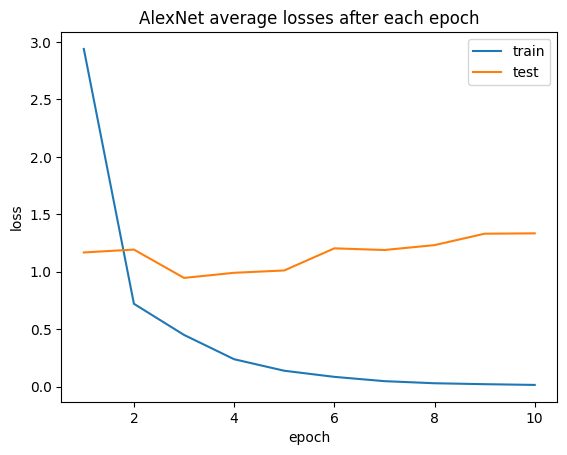

In [11]:
# Step 5: prepare the DataLoader and select your optimizer and set the hyper-parameters for learning the model from DataLoader
#------------------------------------------------------------------------------------------------------------------------------

#cnn_model = AlexNet(number_of_classes)
cnn_model = SimpleCNNv1()
cnn_model.to(device)
print(cnn_model)


learning_rate     = 1e-4
batch_size_val    = 32
epochs            = 10
loss_fn           = nn.CrossEntropyLoss()
optimizer         = torch.optim.Adam(cnn_model.parameters(), lr=learning_rate)
softmax           = nn.Softmax(dim=1) # for calculating the probability of the network prediction. It is used in train_loop() and test_loop().

train_dataloader  = DataLoader(train_dataset, batch_size=batch_size_val, shuffle=True)  # shuffle the images in training set during fine-tuning
test_dataloader   = DataLoader(test_dataset, batch_size=batch_size_val,  shuffle=False) # you don't need to shuffle test images as they are not used during training


train_losses = []
test_losses  = []
train_accuracies = []
test_accuracies = []
start_time = time.time()
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    avg_train_loss, train_accuracy                    = train_loop(train_dataloader, cnn_model, loss_fn, optimizer)
    avg_test_loss, test_accuracy, conf_matrix_test    = test_loop(test_dataloader,   cnn_model, loss_fn)
    # save the losses and accuracies
    train_losses.append(avg_train_loss)
    test_losses.append(avg_test_loss)
    train_accuracies.append(train_accuracy)
    test_accuracies.append(test_accuracy)

print("AlexNet model has been fine-tuned!")
print("Total fine-tuning time: %.3f sec" %( (time.time()-start_time)) )
print("Total fine-tuning time: %.3f hrs" %( (time.time()-start_time)/3600) )

# visualizing the loss curves
plt.plot(range(1,epochs+1), train_losses)
plt.plot(range(1,epochs+1), test_losses)
plt.title('AlexNet average losses after each epoch')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'])
plt.show()


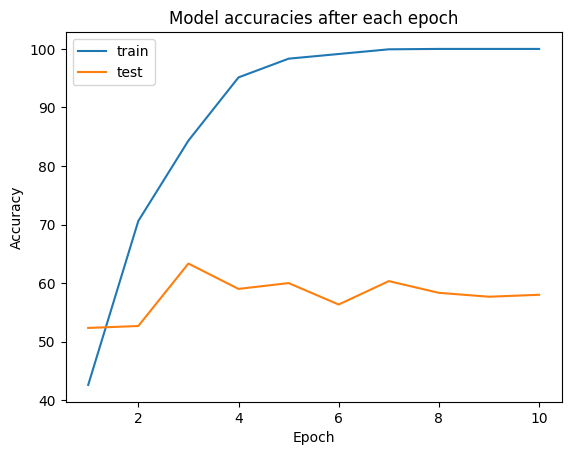

In [12]:
# visualizing the accuracy curves

plt.plot(range(1,epochs+1), train_accuracies)
plt.plot(range(1,epochs+1), test_accuracies)
plt.title('Model accuracies after each epoch')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'])
plt.show()

        bike  cat  dog  person
bike      27    3   11       9
cat        1   57   42       0
dog        0   29   71       0
person     7    7   17      19


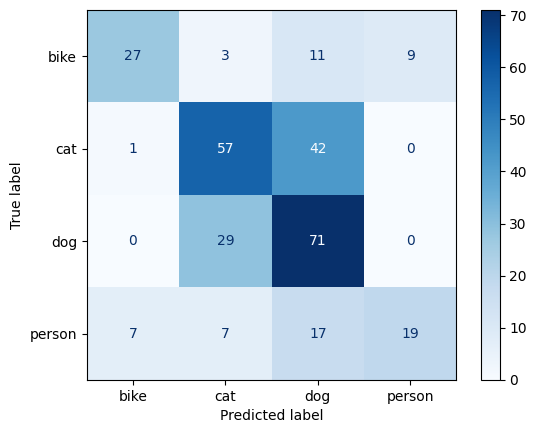

In [13]:
# visualizing the confusion matrix on the test set after the final epoch
dataset_labels = ['bike', 'cat', 'dog', 'person'] # datasets.ImageFolder(): assigns labels according to the sorted order of the folder names

# option #1: text
print(pandas.DataFrame(conf_matrix_test, index = dataset_labels, columns = dataset_labels))

# option #2: prettify
displ = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_test, display_labels=dataset_labels)
displ.plot(cmap="Blues")
plt.show()

Class names: ['bike', 'cat', 'dog', 'person']


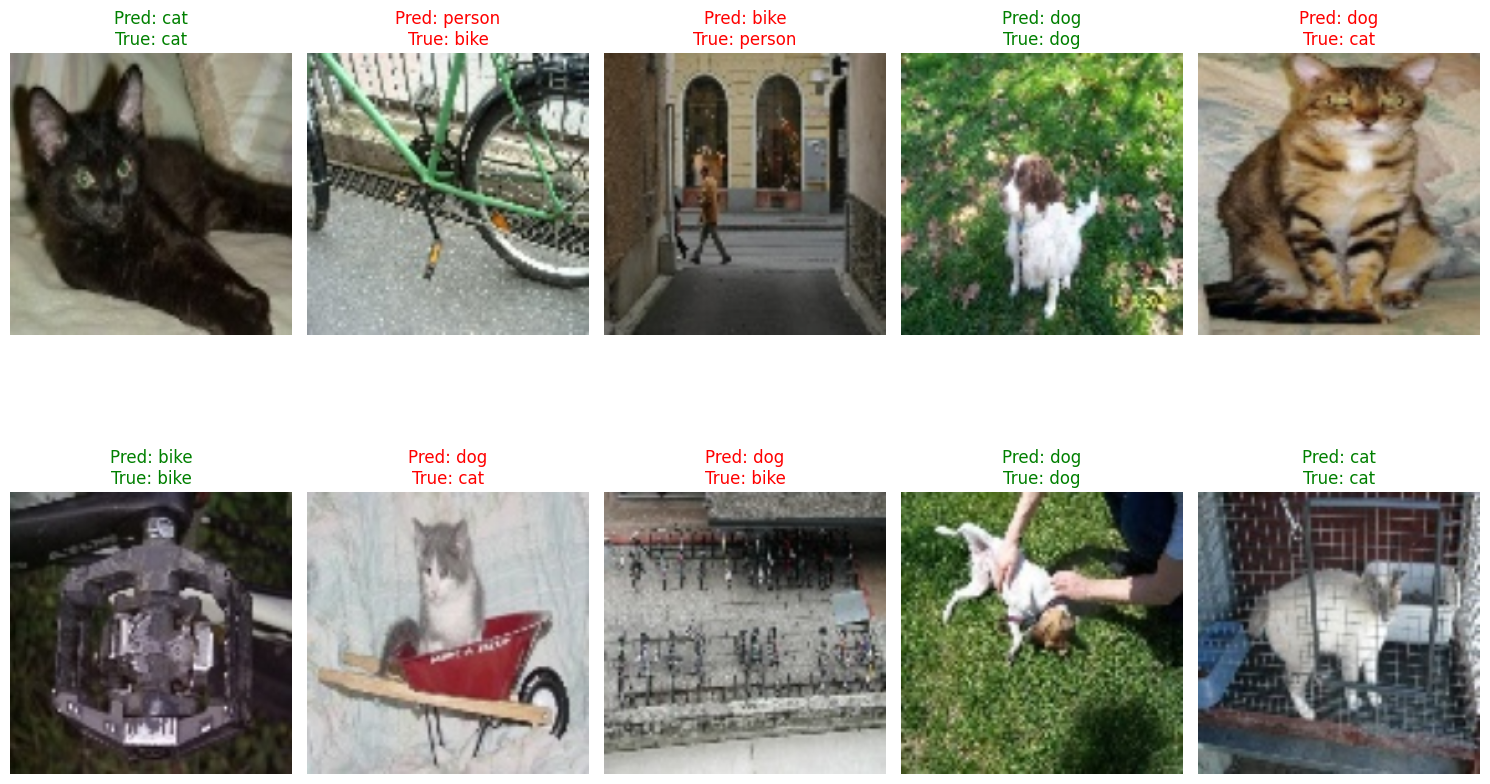

In [14]:
# ChatGPT generated code
# Prompt to ChatGPT: https://chatgpt.com/share/6915f698-2ca8-8001-9ba6-38a7314e8b82

import random
import matplotlib.pyplot as plt
import torch

# helper to unnormalize images for display (reverse the ImageNet normalization)
def unnormalize(img_tensor):
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3,1,1)
    std  = torch.tensor([0.229, 0.224, 0.225]).view(3,1,1)
    return img_tensor * std + mean

# get class names from the dataset object
class_names = test_dataset.classes
print("Class names:", class_names)

# make sure model is in eval mode
cnn_model.eval()

# randomly pick 10 indices from the test set
indices = random.sample(range(len(test_dataset)), 10)

plt.figure(figsize=(15, 10))

with torch.no_grad():
    for i, idx in enumerate(indices):
        img, label = test_dataset[idx]

        # Prepare batch of size 1
        x = img.unsqueeze(0).to(device)

        # model prediction
        pred = cnn_model(x)
        pred_prob = softmax(pred)
        pred_label = torch.argmax(pred_prob, dim=1).item()

        # check if correct
        is_correct = (pred_label == label)

        # unnormalize for display
        disp_img = unnormalize(img).permute(1,2,0).cpu().numpy()

        # plot
        plt.subplot(2, 5, i+1)
        plt.imshow(disp_img)
        plt.axis("off")

        title_color = "green" if is_correct else "red"
        plt.title(f"Pred: {class_names[pred_label]}\nTrue: {class_names[label]}",
                  color=title_color)

plt.tight_layout()
plt.show()